# Image Generator

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [26]:
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()

## Pre-processing
1. Reshaping from (6000, 28, 28) to (6000, 28, 28, 1) 
2. Normalizing the pixel values from [0, 255] to [-1, 1] -> (linear normalization)
3. Shuffling and batching

In [27]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = (train_images - 127.5) / 127.5

In [28]:
batch_size = 256
n_samples = train_images.shape[0]

train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(n_samples).batch(batch_size)

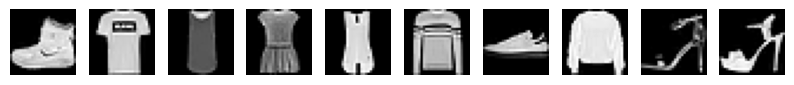

In [29]:
num_images_to_show = 10
plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## Building the generator

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [31]:
def build_generator():
    modelo = Sequential()

    modelo.add(layers.Input(shape=(100,)))
    modelo.add(layers.Dense(7*7*256, use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Reshape((7, 7, 256)))
    modelo.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return modelo


## Generating an imagem using noise

In [32]:
image_generator = build_generator()

In [33]:
noise_dimension = 100
noise = tf.random.normal([1, noise_dimension])

(-0.5, 27.5, 27.5, -0.5)

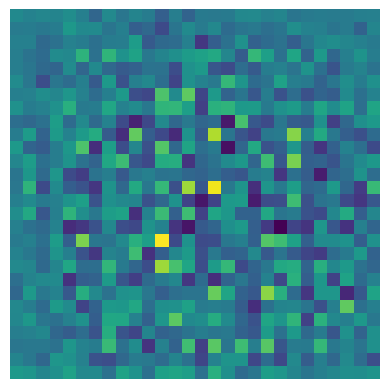

In [34]:
generated_image = image_generator(noise, training=False)
plt.imshow((generated_image[0] * 127.5 + 127.5).numpy()) # The operation of multiplying and adding by 127.5 removes normalization
plt.axis('off')

## Building the discriminator

In [35]:
def build_discriminator():

    model = Sequential()

    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [36]:
image_discriminator = build_discriminator()

## Setting Cost Functions and Optimizers

In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [38]:
def discriminator_cost(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [39]:
def generator_cost(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Setting up Checkpoints

In [41]:
import os

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = image_generator,
                                 discriminator = image_discriminator)

## Setting up Training

In [43]:
import time
from IPython.display import clear_output

In [44]:
epochs = 50
noise_dimension = 100
training_examples = 16

seed = tf.random.normal([training_examples, noise_dimension])

In [45]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = image_generator(noise, training=True)

        real_output = image_discriminator(images, training=True)
        fake_output = image_discriminator(generated_images, training=True)

        gen_loss = generator_cost(fake_output)
        disc_loss = discriminator_cost(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, image_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, image_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, image_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, image_discriminator.trainable_variables))


In [46]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
           train_step(image_batch)

        # Generate imagens to create gif
        clear_output(wait=True)
        generate_and_save_image(image_generator, epoch + 1, seed)

        # Save a checkpoint of the model after 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for the epoch {} is {} s'.format(epoch + 1, time.time()-start))

    # Generate after final epoch
    clear_output(wait=True)
    generate_and_save_image(image_generator, epoch + 1, seed)


In [47]:
def generate_and_save_image(modelo, epoca, entrada):
  # Observe que `training` está definido como False.
  # Isso é para que todas as camadas sejam executadas no modo de inferência (batchnorm).
  previsao = modelo(entrada, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(previsao.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(previsao[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoca))
  plt.show()


## Training and Generating

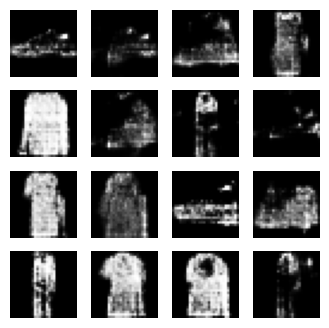

In [48]:
train(train_ds, epochs)

### Saving the model

In [ ]:
image_generator.save("generator_model.keras")

## Restoring from latest checkpoint

In [49]:
def latest_checkpoint_path():
    return tf.train.latest_checkpoint(checkpoint_dir)

checkpoint.restore(latest_checkpoint_path())

## Loading the saved model

In [52]:
from tensorflow.keras.models import load_model

loaded_generator = load_model("generator_model.keras")

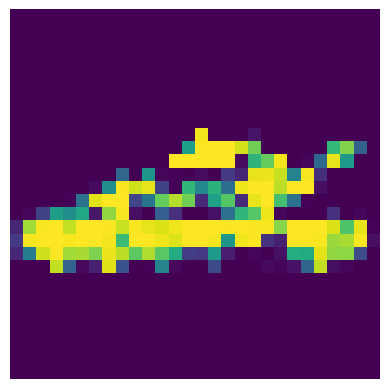

In [54]:
# Generating a new noise
new_noise = tf.random.normal([1, noise_dimension])

# Generating a new image
new_generated_image = loaded_generator(new_noise, training=False)

def removing_normalization(image):
    return image * 127.5 + 127.5

# Visualization of the generated image
plt.imshow((removing_normalization(new_generated_image[0])).numpy())
plt.axis('off')
plt.show()